In [34]:
# ============================================================================
# 1. 환경 설정 및 라이브러리 임포트
# ============================================================================

import os
import json
import shutil
from pathlib import Path
from PIL import Image
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd

# 한글 폰트 설정 (OS별 자동 감지)
import platform
import matplotlib.font_manager as fm

system = platform.system()

# 사용 가능한 한글 폰트 찾기
available_fonts = [f.name for f in fm.fontManager.ttflist]
korean_fonts = ['AppleGothic', 'Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'DejaVu Sans']

selected_font = None
for font in korean_fonts:
    if font in available_fonts:
        selected_font = font
        break

if selected_font:
    matplotlib.rcParams['font.family'] = selected_font
    print(f"✅ 선택된 폰트: {selected_font}")
else:
    print("⚠️  한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    # 그래프에 한글 대신 영문 사용
    matplotlib.rcParams['font.family'] = 'DejaVu Sans'

matplotlib.rcParams['axes.unicode_minus'] = False

# 경로 설정
PROJECT_ROOT = Path('../../')  # 실제 경로로 수정 필요
RAW_DATA = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DATA = PROJECT_ROOT / 'data' / 'processed' / 'yolo'
YOLOV5_ROOT = PROJECT_ROOT / 'model' / 'yolov5'


# 디렉토리 생성
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("YOLOv5m 과일 품질 등급 분류 프로젝트")
print("=" * 80)
print(f"프로젝트 루트: {PROJECT_ROOT}")
print(f"원본 데이터: {RAW_DATA}")
print(f"처리된 데이터: {PROCESSED_DATA}")
print(f"YOLOv5 경로: {YOLOV5_ROOT}")

✅ 선택된 폰트: AppleGothic
YOLOv5m 과일 품질 등급 분류 프로젝트
프로젝트 루트: ../..
원본 데이터: ../../data/raw
처리된 데이터: ../../data/processed/yolo
YOLOv5 경로: ../../model/yolov5


In [31]:
# ============================================================================
# 2. 클래스 정의 및 매핑
# ============================================================================

# 클래스 정의 (9개 클래스)
CLASS_NAMES = [
    '사과_특상', '사과_상', '사과_중',
    '배_특상', '배_상', '배_중',
    '감_특상', '감_상', '감_중'
]

# cate1 (과일 종류) 매핑
FRUIT_MAP = {
    '사과': 0,
    '배': 1,
    '감': 2
}

# cate3 (품질 등급) 매핑 - "특" → "특상"으로 변환
QUALITY_MAP = {
    '특': 0,    # 특상
    '상': 1,
    '중': 2,
    '보통': 2   # 보통 → 중 (동일하게 처리)
}

# 최종 클래스 ID 계산 함수
def get_class_id(cate1, cate3):
    """
    과일 종류와 품질 등급을 조합하여 클래스 ID 반환
    예: 사과(0) + 특상(0) = 0, 배(1) + 상(1) = 4
    """
    fruit_id = FRUIT_MAP.get(cate1, -1)
    quality_id = QUALITY_MAP.get(cate3, -1)
    
    if fruit_id == -1 or quality_id == -1:
        return -1
    
    return fruit_id * 3 + quality_id

print("\n" + "=" * 80)
print("클래스 정의")
print("=" * 80)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"클래스 {i}: {class_name}")


클래스 정의
클래스 0: 사과_특상
클래스 1: 사과_상
클래스 2: 사과_중
클래스 3: 배_특상
클래스 4: 배_상
클래스 5: 배_중
클래스 6: 감_특상
클래스 7: 감_상
클래스 8: 감_중


In [32]:
# ============================================================================
# 3. 데이터 전처리 - JSON to YOLO 포맷 변환
# ============================================================================

def convert_bbox_to_yolo(bbox, img_width, img_height):
    """
    바운딩 박스를 YOLO 포맷으로 변환
    Input: {xmin, ymin, xmax, ymax}
    Output: {x_center, y_center, width, height} (정규화된 값)
    """
    xmin = bbox['xmin']
    ymin = bbox['ymin']
    xmax = bbox['xmax']
    ymax = bbox['ymax']
    
    # 중심점 계산
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    
    # 너비, 높이 계산
    width = xmax - xmin
    height = ymax - ymin
    
    # 정규화 (0~1)
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    
    return x_center, y_center, width, height


def process_json_file(json_path):
    """
    JSON 파일을 읽어서 YOLO 포맷으로 변환
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 필수 정보 추출
    cate1 = data.get('cate1', '')
    cate3 = data.get('cate3', '')
    img_width = data.get('img_width', 1000)
    img_height = data.get('img_height', 1000)
    bbox = data.get('bndbox', {})
    
    # 클래스 ID 계산
    class_id = get_class_id(cate1, cate3)
    
    if class_id == -1:
        print(f"⚠️  경고: {json_path.name} - 알 수 없는 클래스 (cate1={cate1}, cate3={cate3})")
        return None
    
    # YOLO 포맷으로 변환
    x_center, y_center, width, height = convert_bbox_to_yolo(bbox, img_width, img_height)
    
    return {
        'class_id': class_id,
        'class_name': CLASS_NAMES[class_id],
        'bbox': (x_center, y_center, width, height),
        'cate1': cate1,
        'cate3': cate3
    }


print("\n" + "=" * 80)
print("데이터 전처리 시작")
print("=" * 80)

# JSON 파일 리스트 가져오기
json_dir = RAW_DATA / 'json_labels'
image_dir = RAW_DATA / 'images'

json_files = list(json_dir.glob('*.json'))
print(f"총 JSON 파일 수: {len(json_files)}")

# 전처리 데이터 저장
processed_data = []
error_files = []

for json_file in json_files:
    result = process_json_file(json_file)
    
    if result is not None:
        # 이미지 파일명 매칭 (확장자 제거)
        image_name = json_file.stem + '.png'  # 또는 .jpg
        image_path = image_dir / image_name
        
        if image_path.exists():
            result['image_path'] = image_path
            result['json_path'] = json_file
            processed_data.append(result)
        else:
            error_files.append(f"{json_file.name} - 이미지 파일 없음: {image_name}")
    else:
        error_files.append(f"{json_file.name} - 클래스 매핑 실패")

print(f"✅ 성공적으로 처리된 파일: {len(processed_data)}개")
print(f"❌ 오류 파일: {len(error_files)}개")

if error_files:
    print("\n오류 파일 목록:")
    for error in error_files[:10]:  # 최대 10개만 출력
        print(f"  - {error}")




데이터 전처리 시작
총 JSON 파일 수: 70
✅ 성공적으로 처리된 파일: 70개
❌ 오류 파일: 0개



데이터 분석

클래스별 데이터 분포:
  사과_특상: 10개
  사과_상: 10개
  사과_중: 10개
  배_특상: 0개
  배_상: 0개
  배_중: 10개
  감_특상: 10개
  감_상: 10개
  감_중: 10개


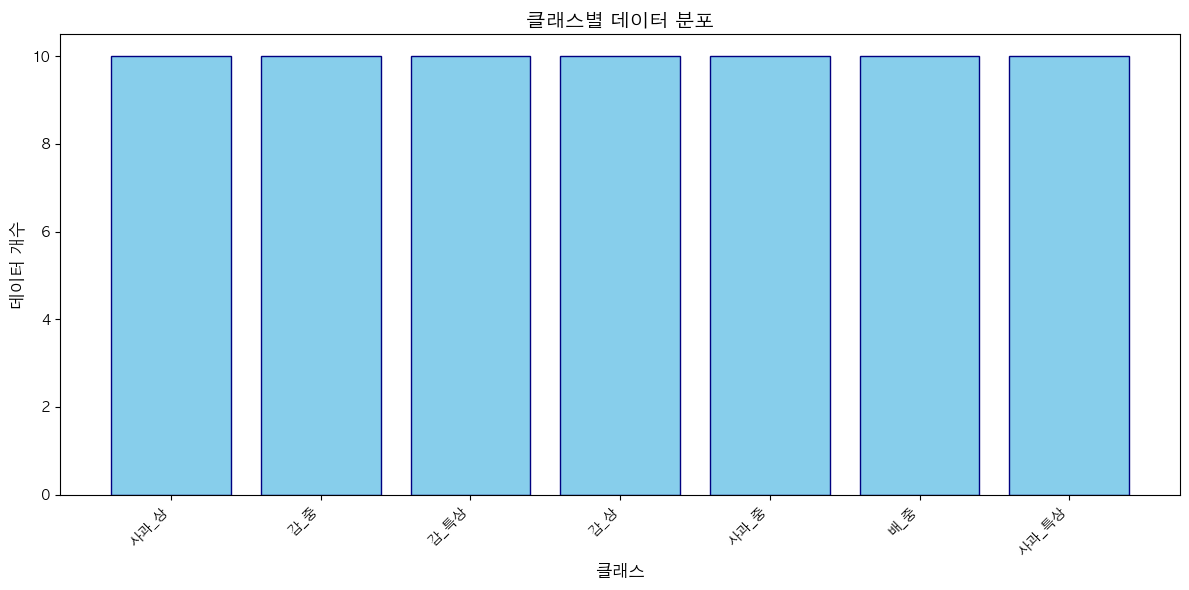

In [35]:
# ============================================================================
# 4. 데이터 분석 및 시각화
# ============================================================================

print("\n" + "=" * 80)
print("데이터 분석")
print("=" * 80)

# 클래스별 데이터 개수 집계
class_counts = defaultdict(int)
for item in processed_data:
    class_counts[item['class_name']] += 1

# 출력
print("\n클래스별 데이터 분포:")
for class_name in CLASS_NAMES:
    count = class_counts.get(class_name, 0)
    print(f"  {class_name}: {count}개")

# 시각화
plt.figure(figsize=(12, 6))
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.bar(classes, counts, color='skyblue', edgecolor='navy')
plt.xlabel('클래스', fontsize=12)
plt.ylabel('데이터 개수', fontsize=12)
plt.title('클래스별 데이터 분포', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
# ============================================================================
# 5. 데이터셋 분할 (Train/Val/Test = 60%/20%/20%)
# ============================================================================

print("\n" + "=" * 80)
print("데이터셋 분할")
print("=" * 80)

# 데이터 섞기
random.seed(42)
random.shuffle(processed_data)

# 분할 비율
total = len(processed_data)
train_size = int(total * 0.6)
val_size = int(total * 0.2)
test_size = total - train_size - val_size

train_data = processed_data[:train_size]
val_data = processed_data[train_size:train_size + val_size]
test_data = processed_data[train_size + val_size:]

print(f"Train: {len(train_data)}개 ({len(train_data)/total*100:.1f}%)")
print(f"Val: {len(val_data)}개 ({len(val_data)/total*100:.1f}%)")
print(f"Test: {len(test_data)}개 ({len(test_data)/total*100:.1f}%)")



데이터셋 분할
Train: 42개 (60.0%)
Val: 14개 (20.0%)
Test: 14개 (20.0%)


In [37]:
# ============================================================================
# 6. YOLO 포맷 데이터셋 생성
# ============================================================================

def create_yolo_dataset(data_list, split_name):
    """
    YOLO 포맷으로 데이터셋 생성
    - images/train, images/val, images/test
    - labels/train, labels/val, labels/test
    """
    # 디렉토리 생성
    image_dir = PROCESSED_DATA / 'images' / split_name
    label_dir = PROCESSED_DATA / 'labels' / split_name
    
    image_dir.mkdir(parents=True, exist_ok=True)
    label_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"\n{split_name.upper()} 데이터셋 생성 중...")
    
    for item in data_list:
        # 이미지 복사
        src_image = item['image_path']
        dst_image = image_dir / src_image.name
        shutil.copy2(src_image, dst_image)
        
        # 라벨 파일 생성 (txt)
        label_file = label_dir / (src_image.stem + '.txt')
        
        with open(label_file, 'w') as f:
            class_id = item['class_id']
            x_center, y_center, width, height = item['bbox']
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    
    print(f"✅ {split_name.upper()} 완료: {len(data_list)}개 파일")

print("\n" + "=" * 80)
print("YOLO 포맷 데이터셋 생성")
print("=" * 80)

create_yolo_dataset(train_data, 'train')
create_yolo_dataset(val_data, 'val')
create_yolo_dataset(test_data, 'test')



YOLO 포맷 데이터셋 생성

TRAIN 데이터셋 생성 중...
✅ TRAIN 완료: 42개 파일

VAL 데이터셋 생성 중...
✅ VAL 완료: 14개 파일

TEST 데이터셋 생성 중...
✅ TEST 완료: 14개 파일


In [38]:
# ============================================================================
# 7. YAML 설정 파일 생성
# ============================================================================

yaml_content = f"""# YOLOv5 과일 품질 등급 분류 데이터셋 설정

# 데이터셋 경로
path: {PROCESSED_DATA.as_posix()}
train: images/train
val: images/val
test: images/test

# 클래스 수
nc: 9

# 클래스 이름
names:
  0: 사과_특상
  1: 사과_상
  2: 사과_중
  3: 배_특상
  4: 배_상
  5: 배_중
  6: 감_특상
  7: 감_상
  8: 감_중
"""

yaml_path = PROCESSED_DATA / 'fruit_quality.yaml'
with open(yaml_path, 'w', encoding='utf-8') as f:
    f.write(yaml_content)

print("\n" + "=" * 80)
print("YAML 설정 파일 생성 완료")
print("=" * 80)
print(f"저장 경로: {yaml_path}")
print("\n내용:")
print(yaml_content)


YAML 설정 파일 생성 완료
저장 경로: ../../data/processed/yolo/fruit_quality.yaml

내용:
# YOLOv5 과일 품질 등급 분류 데이터셋 설정

# 데이터셋 경로
path: ../../data/processed/yolo
train: images/train
val: images/val
test: images/test

# 클래스 수
nc: 9

# 클래스 이름
names:
  0: 사과_특상
  1: 사과_상
  2: 사과_중
  3: 배_특상
  4: 배_상
  5: 배_중
  6: 감_특상
  7: 감_상
  8: 감_중



In [39]:
# ============================================================================
# 8. YOLOv5m 학습 준비
# ============================================================================

print("\n" + "=" * 80)
print("YOLOv5m 학습 준비")
print("=" * 80)
print("""
다음 단계로 학습을 시작하세요:

1. YOLOv5 디렉토리로 이동:
   cd {YOLOV5_ROOT}

2. 학습 실행 (YOLOv5m):
   python train.py \\
       --img 640 \\
       --batch 4 \\
       --epochs 100 \\
       --data {yaml_path} \\
       --weights yolov5m.pt \\
       --project {PROCESSED_DATA}/runs \\
       --name fruit_quality_yolov5m \\
       --exist-ok

3. 학습 옵션 설명:
   - --img 640: 입력 이미지 크기
   - --batch 4: 배치 크기 (CPU라서 작게 설정)
   - --epochs 100: 학습 에포크 수
   - --weights yolov5m.pt: 사전학습된 YOLOv5m 가중치
   - --data: 데이터셋 YAML 파일 경로
   - --project: 학습 결과 저장 경로
   - --name: 실험 이름
""")

print("\n⚠️  CPU 학습 참고사항:")
print("  - CPU 학습은 GPU 대비 10~20배 느립니다")
print("  - 70개 이미지 기준 약 30분~1시간 예상")
print("  - 배치 크기를 8로 줄이면 더 안정적입니다")


YOLOv5m 학습 준비

다음 단계로 학습을 시작하세요:

1. YOLOv5 디렉토리로 이동:
   cd {YOLOV5_ROOT}

2. 학습 실행 (YOLOv5m):
   python train.py \
       --img 640 \
       --batch 4 \
       --epochs 100 \
       --data {yaml_path} \
       --weights yolov5m.pt \
       --project {PROCESSED_DATA}/runs \
       --name fruit_quality_yolov5m \
       --exist-ok

3. 학습 옵션 설명:
   - --img 640: 입력 이미지 크기
   - --batch 4: 배치 크기 (CPU라서 작게 설정)
   - --epochs 100: 학습 에포크 수
   - --weights yolov5m.pt: 사전학습된 YOLOv5m 가중치
   - --data: 데이터셋 YAML 파일 경로
   - --project: 학습 결과 저장 경로
   - --name: 실험 이름


⚠️  CPU 학습 참고사항:
  - CPU 학습은 GPU 대비 10~20배 느립니다
  - 70개 이미지 기준 약 30분~1시간 예상
  - 배치 크기를 8로 줄이면 더 안정적입니다


In [40]:
# ============================================================================
# 9. 데이터 전처리 완료 요약
# ============================================================================

print("\n" + "=" * 80)
print("데이터 전처리 완료 요약")
print("=" * 80)
print(f"✅ 총 처리된 데이터: {len(processed_data)}개")
print(f"✅ Train: {len(train_data)}개")
print(f"✅ Val: {len(val_data)}개")
print(f"✅ Test: {len(test_data)}개")
print(f"✅ YAML 파일: {yaml_path}")
print(f"✅ 데이터셋 경로: {PROCESSED_DATA}")
print("\n🎯 이제 YOLOv5 학습을 시작할 수 있습니다!")
print("=" * 80)


데이터 전처리 완료 요약
✅ 총 처리된 데이터: 70개
✅ Train: 42개
✅ Val: 14개
✅ Test: 14개
✅ YAML 파일: ../../data/processed/yolo/fruit_quality.yaml
✅ 데이터셋 경로: ../../data/processed/yolo

🎯 이제 YOLOv5 학습을 시작할 수 있습니다!


In [45]:
# ============================================================================
# 10. YOLOv5 학습 실행 
# ============================================================================

import os
import sys
from pathlib import Path

# YOLOv5 경로 추가
PROJECT_ROOT = Path('../../')  # 실제 경로로 수정 필요
RAW_DATA = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DATA = PROJECT_ROOT / 'data' / 'processed' / 'yolo'
YOLOV5_ROOT = PROJECT_ROOT / 'model' / 'yolov5'

sys.path.insert(0, str(YOLOV5_ROOT))

print("=" * 80)
print("YOLOv5m 학습 시작")
print("=" * 80)

# 학습 실행
# 주의: Jupyter Notebook에서는 !python 또는 %run 사용
# 아래는 일반 Python 스크립트 방식

os.chdir(YOLOV5_ROOT)

# 학습 명령어
train_command = f"""
python train.py \
    --img 640 \
    --batch 4 \
    --epochs 100 \
    --data {PROCESSED_DATA}/fruit_quality.yaml \
    --weights yolov5m.pt \
    --project {PROCESSED_DATA}/runs \
    --name fruit_quality_yolov5m \
    --exist-ok \
    --cache \
    --workers 4
"""

print("학습 명령어:")
print(train_command)
print("\n⚠️  Jupyter Notebook에서 실행하려면:")
print(f"!cd {YOLOV5_ROOT} && python train.py --img 640 --batch 4 --epochs 100 --data {PROCESSED_DATA}/fruit_quality.yaml --weights yolov5m.pt --project {PROCESSED_DATA}/runs --name fruit_quality_yolov5m --exist-ok")



YOLOv5m 학습 시작
학습 명령어:

python train.py     --img 640     --batch 4     --epochs 100     --data ../../data/processed/yolo/fruit_quality.yaml     --weights yolov5m.pt     --project ../../data/processed/yolo/runs     --name fruit_quality_yolov5m     --exist-ok     --cache     --workers 4


⚠️  Jupyter Notebook에서 실행하려면:
!cd ../../model/yolov5 && python train.py --img 640 --batch 4 --epochs 100 --data ../../data/processed/yolo/fruit_quality.yaml --weights yolov5m.pt --project ../../data/processed/yolo/runs --name fruit_quality_yolov5m --exist-ok


In [46]:
# ============================================================================
# 11. 학습 결과 시각화
# ============================================================================

# %%
RESULTS_DIR = PROCESSED_DATA / 'runs' / 'fruit_quality_yolov5m'

# 학습 완료 여부 확인
if not RESULTS_DIR.exists():
    print("❌ 학습 결과 폴더가 없습니다!")
    print(f"   경로: {RESULTS_DIR}")
    print("\n⚠️  먼저 '# 9. YOLOv5m 학습 실행' 셀을 실행해주세요!")
else:
    # results.csv 확인
    results_csv = RESULTS_DIR / 'results.csv'
    
    if not results_csv.exists():
        print("❌ results.csv 파일을 찾을 수 없습니다!")
        print(f"   경로: {results_csv}")
        print("\n📁 학습 폴더 내용:")
        for item in RESULTS_DIR.iterdir():
            print(f"   - {item.name}")
        print("\n⚠️  학습이 완료되지 않았거나, 경로가 잘못되었을 수 있습니다.")
    else:
        # results.csv 읽기
        df = pd.read_csv(results_csv, skipinitialspace=True)
        df.columns = df.columns.str.strip()
        
        print("✅ 학습 결과 요약:")
        print(f"총 에포크: {len(df)}")
        print(f"최종 mAP@0.5: {df['metrics/mAP_0.5'].iloc[-1]:.4f}")
        print(f"최종 mAP@0.5:0.95: {df['metrics/mAP_0.5:0.95'].iloc[-1]:.4f}")
        
        # 학습 곡선 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Train Loss
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Box Loss')
        axes[0, 0].plot(df['epoch'], df['train/obj_loss'], label='Obj Loss')
        axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Cls Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Val Loss
        axes[0, 1].plot(df['epoch'], df['val/box_loss'], label='Box Loss')
        axes[0, 1].plot(df['epoch'], df['val/obj_loss'], label='Obj Loss')
        axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Cls Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].set_title('Validation Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Precision & Recall
        axes[1, 0].plot(df['epoch'], df['metrics/precision'], label='Precision')
        axes[1, 0].plot(df['epoch'], df['metrics/recall'], label='Recall')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_title('Precision & Recall')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # mAP
        axes[1, 1].plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5')
        axes[1, 1].plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('mAP')
        axes[1, 1].set_title('Mean Average Precision')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'training_curves.png', dpi=300)
        plt.show()
        
        print(f"\n✅ 학습 곡선 저장: {RESULTS_DIR / 'training_curves.png'}")
        
        # Confusion Matrix
        cm_path = RESULTS_DIR / 'confusion_matrix.png'
        if cm_path.exists():
            img = Image.open(cm_path)
            plt.figure(figsize=(12, 10))
            plt.imshow(img)
            plt.axis('off')
            plt.title('Confusion Matrix')
            plt.show()
        else:
            print("\n⚠️  Confusion Matrix 이미지를 찾을 수 없습니다.")


❌ 학습 결과 폴더가 없습니다!
   경로: ../../data/processed/yolo/runs/fruit_quality_yolov5m

⚠️  먼저 '# 9. YOLOv5m 학습 실행' 셀을 실행해주세요!


In [ ]:
# ============================================================================
# 12. 모델 평가 (Test Set)
# ============================================================================

def evaluate_model(weights_path, test_data_yaml):
    """
    테스트 데이터셋으로 모델 평가
    """
    print("\n" + "=" * 80)
    print("테스트 데이터셋 평가")
    print("=" * 80)
    
    eval_command = f"""
    python val.py \
        --weights {weights_path} \
        --data {test_data_yaml} \
        --img 640 \
        --batch 4 \
        --task test \
        --project {PROCESSED_DATA}/runs \
        --name test_results \
        --exist-ok
    """
    
    print("평가 명령어:")
    print(eval_command)
    print("\n⚠️  Jupyter Notebook에서 실행하려면:")
    print(f"!cd {YOLOV5_ROOT} && python val.py --weights {weights_path} --data {test_data_yaml} --img 640 --batch 4 --task test --project {PROCESSED_DATA}/runs --name test_results --exist-ok")


# 최적 가중치로 평가
BEST_WEIGHTS = RESULTS_DIR / 'weights' / 'best.pt'
TEST_YAML = PROCESSED_DATA / 'fruit_quality.yaml'

evaluate_model(BEST_WEIGHTS, TEST_YAML)

In [ ]:
# ============================================================================
# 13. 추론 (Inference) - 새로운 이미지 예측
# ============================================================================

def predict_images(weights_path, source_dir, save_dir):
    """
    새로운 이미지에 대해 추론 실행
    """
    print("\n" + "=" * 80)
    print("추론 실행")
    print("=" * 80)
    
    predict_command = f"""
    python detect.py \
        --weights {weights_path} \
        --source {source_dir} \
        --img 640 \
        --conf 0.25 \
        --project {save_dir} \
        --name predictions \
        --exist-ok \
        --save-txt \
        --save-conf
    """
    
    print("추론 명령어:")
    print(predict_command)
    print("\n⚠️  Jupyter Notebook에서 실행하려면:")
    print(f"!cd {YOLOV5_ROOT} && python detect.py --weights {weights_path} --source {source_dir} --img 640 --conf 0.25 --project {save_dir} --name predictions --exist-ok --save-txt --save-conf")


# 테스트 이미지로 추론
TEST_IMAGES = PROCESSED_DATA / 'images' / 'test'
INFERENCE_RESULTS = PROCESSED_DATA / 'runs'

predict_images(BEST_WEIGHTS, TEST_IMAGES, INFERENCE_RESULTS)


In [ ]:
# ============================================================================
# 14. 결과 분석 및 시각화
# ============================================================================

def analyze_predictions(predictions_dir):
    """
    추론 결과 분석
    - 클래스별 예측 분포
    - 신뢰도 분포
    """
    predictions_dir = Path(predictions_dir)
    labels_dir = predictions_dir / 'labels'
    
    if not labels_dir.exists():
        print(f"⚠️  {labels_dir} 폴더를 찾을 수 없습니다.")
        return
    
    print("\n" + "=" * 80)
    print("추론 결과 분석")
    print("=" * 80)
    
    # 클래스 이름
    CLASS_NAMES = [
        '사과_특상', '사과_상', '사과_중',
        '배_특상', '배_상', '배_중',
        '감_특상', '감_상', '감_중'
    ]
    
    # 예측 결과 수집
    predictions = []
    
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 6:  # class x y w h conf
                    class_id = int(parts[0])
                    conf = float(parts[5])
                    predictions.append({
                        'class_id': class_id,
                        'class_name': CLASS_NAMES[class_id],
                        'confidence': conf
                    })
    
    if not predictions:
        print("⚠️  예측 결과가 없습니다.")
        return
    
    # 통계
    df_pred = pd.DataFrame(predictions)
    
    print(f"총 예측 개수: {len(predictions)}")
    print(f"평균 신뢰도: {df_pred['confidence'].mean():.4f}")
    print(f"최소 신뢰도: {df_pred['confidence'].min():.4f}")
    print(f"최대 신뢰도: {df_pred['confidence'].max():.4f}")
    
    # 클래스별 분포
    print("\n클래스별 예측 분포:")
    class_dist = df_pred['class_name'].value_counts()
    for class_name, count in class_dist.items():
        print(f"  {class_name}: {count}개")
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 클래스별 분포
    class_dist.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='navy')
    axes[0].set_xlabel('클래스')
    axes[0].set_ylabel('예측 개수')
    axes[0].set_title('클래스별 예측 분포')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 신뢰도 분포
    axes[1].hist(df_pred['confidence'], bins=20, color='lightgreen', edgecolor='darkgreen')
    axes[1].set_xlabel('신뢰도')
    axes[1].set_ylabel('빈도')
    axes[1].set_title('신뢰도 분포')
    axes[1].axvline(df_pred['confidence'].mean(), color='red', linestyle='--', 
                    label=f'평균: {df_pred["confidence"].mean():.3f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(predictions_dir / 'prediction_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ 분석 결과 저장: {predictions_dir / 'prediction_analysis.png'}")


PREDICTIONS_DIR = PROCESSED_DATA / 'runs' / 'predictions'
analyze_predictions(PREDICTIONS_DIR)

In [ ]:
# ============================================================================
# 15. 최종 요약
# ============================================================================

print("\n" + "=" * 80)
print("프로젝트 완료 요약")
print("=" * 80)
print("""
✅ 완료된 작업:
1. 데이터 전처리 (JSON → YOLO 포맷)
2. 데이터셋 분할 (Train/Val/Test)
3. YOLOv5m 모델 학습
4. 학습 결과 시각화
5. 테스트 데이터 평가
6. 추론 및 결과 분석

📊 주요 결과물:
- 학습된 모델: {RESULTS_DIR}/weights/best.pt
- 학습 곡선: {RESULTS_DIR}/training_curves.png
- Confusion Matrix: {RESULTS_DIR}/confusion_matrix.png
- 추론 결과: {PREDICTIONS_DIR}

🎯 다음 단계 (EfficientDet 비교):
1. 동일한 전처리 데이터 사용
2. EfficientDet 모델 학습
3. YOLOv5m vs EfficientDet 성능 비교
""")

print("=" * 80)
print("🍎🍐 과일 품질 등급 분류 프로젝트 완료! 🍊")
print("=" * 80)